# Лінійна регресія: перенавчання і регуляризація

У цьому завданні ми на прикладах побачимо, як перенавчаються лінійні моделі, розберемо, чому так відбувається, і з'ясуємо, як діагностувати та контролювати перенавчання.

В усіх комірках, де вказаний коментар з інструкціями, потрібно написати код, який виконує ці інструкції. Решту комірок із кодом (без коментарів) треба просто виконати. Крім того, у завданні необхідно відповідати на запитання; відповіді потрібно вписувати після виділеного слова "__Відповідь:__".

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

Ми будемо працювати з датасетом __"bikes_rent.csv"__, у якому по днях записані календарна інформація та погодні умови, що характеризують автоматизовані пункти прокату велосипедів, а також кількість прокатів у цей день. Останнє ми будемо передбачати; таким чином, ми будемо розв'язувати завдання регресії.

### Ознайомлення з даними

## Завдання 1

Завантажте датасет за допомогою функції __pandas.read_csv__ у змінну __df__. Виведіть перші 5 рядків, щоб переконатися в коректному зчитуванні даних:

In [4]:
from google.colab import files
import pandas as pd

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

df = pd.read_csv(fn)
df.head()
# df = pd.read_csv('bikes_rent.csv')
# df.head()

Saving bikes_rent.csv to bikes_rent.csv
User uploaded file "bikes_rent.csv" with length 50254 bytes


,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed(mph),windspeed(ms),cnt
0,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,4.805490,985
1,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,7.443949,801
2,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,7.437060,1349
3,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,4.800998,1562
4,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,5.597810,1600


Для кожного дня прокату відомі такі ознаки:
* _season_: 1 — весна, 2 — літо, 3 — осінь, 4 — зима
* _yr_: 0 — 2011, 1 — 2012
* _mnth_: від 1 до 12
* _holiday_: 0 — немає свята, 1 — є свято
* _weekday_: від 0 до 6
* _workingday_: 0 — неробочий день, 1 — робочий день
* _weathersit_: оцінка сприятливості погоди від 1 (чистий, ясний день) до 4 (злива, туман)
* _temp_: температура в Цельсіях
* _atemp_: температура за відчуттями в Цельсіях
* _hum_: вологість
* _windspeed(mph)_: швидкість вітру в милях за годину
* _windspeed(ms)_: швидкість вітру в метрах за секунду
* _cnt_: кількість орендованих велосипедів (це цільова ознака, її ми будемо передбачати)

Отже, у нас є речові, бінарні та номінальні (порядкові) ознаки, і з усіма з них можна працювати як з речовими. З номінальними ознаками теж можна працювати як з речовими, тому що на них заданий порядок. Давайте подивимося на графіках, як цільова ознака залежить від решти.

Побудуйте графіки залежностей атрибутів від кількості поїздок. Іншими словами, вам потрібно побудувати 12 графіків. На кожному має бути зображена залежність чергового атрибута від змінної **cnt**.

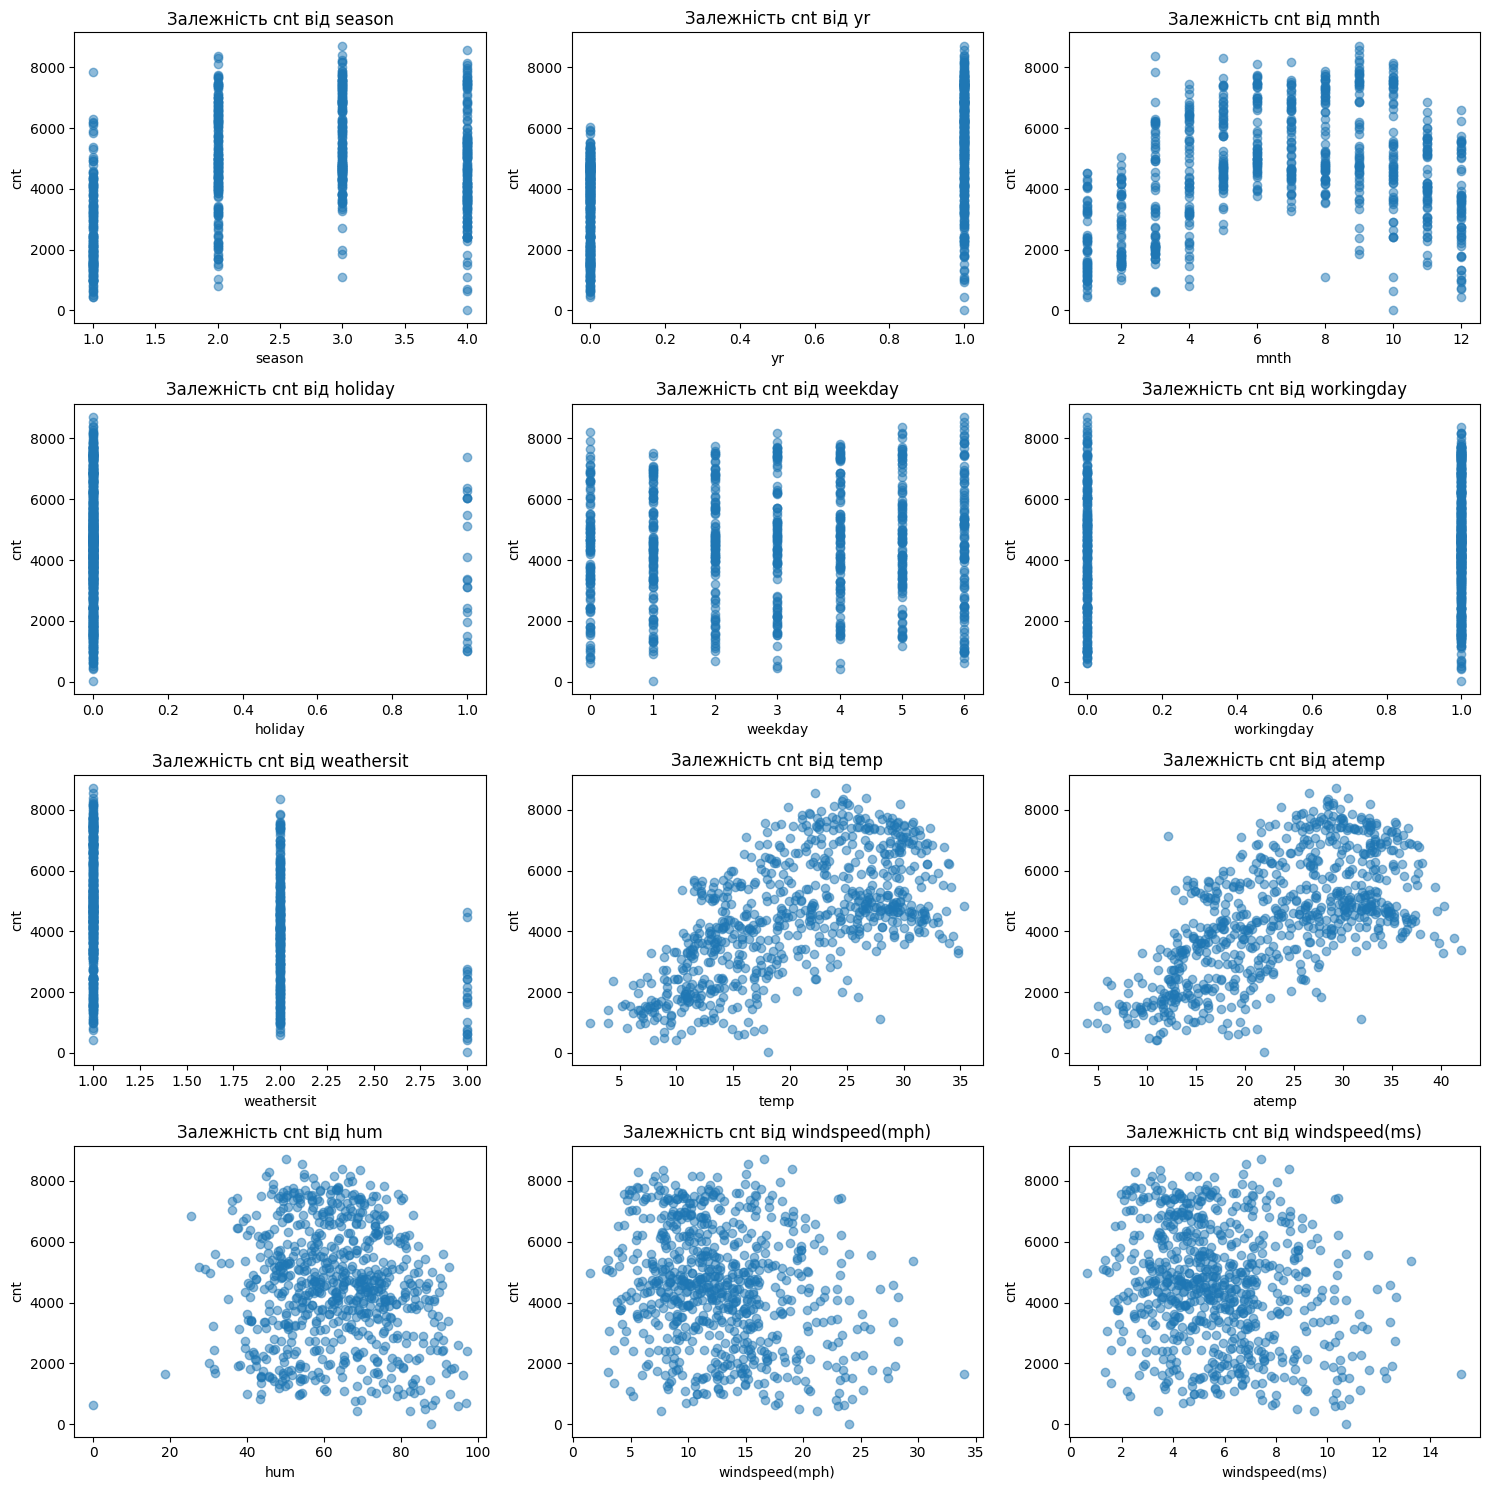

In [5]:
# Побудова графіків залежностей кожного атрибуту від змінної cnt
fig, axes = plt.subplots(4, 3, figsize=(15, 15))
axes = axes.ravel()

for i, col in enumerate(df.columns[:-1]):  # Остання колонка — це цільова змінна
    axes[i].scatter(df[col], df['cnt'], alpha=0.5)
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('cnt')
    axes[i].set_title(f'Залежність cnt від {col}')

plt.tight_layout()
plt.show()


__Запитання:__
1. Яким є характер залежності кількості прокатів від місяця?
1. Вкажіть одну або дві ознаки, від яких кількість прокатів скоріше за все залежить лінійно.

__Відповіді:__
1. Можна побачити логічну сезонність: чим холодніше місяць - тим менше оренд.
2. Лінійну залежність я тут не бачу.
Можна натягнути залежність від року, проте ми маємо всього 2 роки і, як на мене, цього замало, щоб говорити про релевантність вибірки.
Другий параметр певно мався на увазі температура (або температура по відчуттям), проте певен, якщо брати новіші дані з умовою підняття температури на землі, то цей графік є параболою, оскільки при температурі вище 25 градусів (що є піком) попит на велосипеди падає.

## Завдання 2

Давайте більш строго оцінимо рівень лінійної залежності між ознаками та цільовою змінною. Гарною мірою лінійної залежності між двома векторами є кореляція Пірсона. Нам уже доводилося мати з нею справу раніше. Для її обчислення в pandas можна використовувати методи датафрейму: corr і corrwith.

Порахуйте кореляції всіх ознак, окрім останньої, з останньою за допомогою методу `corrwith`.

In [7]:
correlations = df.corrwith(df['cnt'])
print("Кореляції між ознаками і змінною 'cnt':")
print(correlations)

Кореляції між ознаками і змінною 'cnt':
season            0.406100
yr                0.566710
mnth              0.279977
holiday          -0.068348
weekday           0.067443
workingday        0.061156
weathersit       -0.297391
temp              0.627494
atemp             0.631066
hum              -0.100659
windspeed(mph)   -0.234545
windspeed(ms)    -0.234545
cnt               1.000000
dtype: float64


У вибірці є ознаки, що корелюють із цільовою, а отже, завдання можна розв'язувати лінійними методами.

За графіками видно, що деякі ознаки схожі між собою. Тому давайте також порахуємо кореляції між речовими ознаками.

## Завдання 3

Порахуйте попарні кореляції між ознаками temp, atemp, hum, windspeed(mph), windspeed(ms) і cnt
за допомогою методу corr:

In [11]:
# Обчислення попарних кореляцій між речовими ознаками
correlation_matrix = df[['temp', 'atemp', 'hum', 'windspeed(mph)', 'windspeed(ms)', 'cnt']].corr()
print("Матриця кореляцій між речовими ознаками:")
print(correlation_matrix)

Матриця кореляцій між речовими ознаками:
                    temp     atemp       hum  windspeed(mph)  windspeed(ms)  \
temp            1.000000  0.991702  0.126963       -0.157944      -0.157944   
atemp           0.991702  1.000000  0.139988       -0.183643      -0.183643   
hum             0.126963  0.139988  1.000000       -0.248489      -0.248489   
windspeed(mph) -0.157944 -0.183643 -0.248489        1.000000       1.000000   
windspeed(ms)  -0.157944 -0.183643 -0.248489        1.000000       1.000000   
cnt             0.627494  0.631066 -0.100659       -0.234545      -0.234545   

                     cnt  
temp            0.627494  
atemp           0.631066  
hum            -0.100659  
windspeed(mph) -0.234545  
windspeed(ms)  -0.234545  
cnt             1.000000  


На діагоналях, як і належить, стоять одиниці. Однак у матриці є ще дві пари сильно корелюючих стовпців: temp і atemp (корелюють за своєю природою) і два windspeed (тому що це просто переведення одних одиниць в інші). Далі ми побачимо, що цей факт негативно позначається на навчанні лінійної моделі.

Насамкінець подивимося середні ознак (метод mean), щоб оцінити масштаб ознак і частки 1 у бінарних ознак.

## Завдання 4

Виведіть середні ознак.

In [12]:
# Виведення середніх значень ознак
means = df.mean()
print("Середні значення ознак:")
print(means)

Середні значення ознак:
season               2.496580
yr                   0.500684
mnth                 6.519836
holiday              0.028728
weekday              2.997264
workingday           0.683995
weathersit           1.395349
temp                20.310776
atemp               23.717699
hum                 62.789406
windspeed(mph)      12.762576
windspeed(ms)        5.705220
cnt               4504.348837
dtype: float64


Ознаки мають різний масштаб, отже, для подальшої роботи нам краще нормувати матрицю об'єкти-ознаки.

### Проблема перша: колінеарні ознаки

Отже, у наших даних одна ознака дублює іншу, і є ще дві дуже схожі. Звичайно, ми могли б одразу видалити дублікати, але давайте подивимося, як відбувалося б навчання моделі, якби ми не помітили цю проблему.

Для початку проведемо масштабування, або стандартизацію ознак: з кожної ознаки віднімемо її середнє і поділимо на стандартне відхилення. Це можна зробити за допомогою методу scale.

Крім того, необхідно перемішати вибірку, це буде потрібно для крос-валідації.

In [13]:
from sklearn.preprocessing import scale
from sklearn.utils import shuffle

In [14]:
df_shuffled = shuffle(df, random_state=42)
X = scale(df_shuffled[df_shuffled.columns[:-1]])
y = df_shuffled["cnt"]

Давайте навчимо лінійну регресію на наших даних і подивимося на ваги ознак.

In [16]:
from sklearn.linear_model import LinearRegression

# Навчання лінійної регресії
X = df.drop(columns=['cnt'])
y = df['cnt']

model = LinearRegression()
model.fit(X, y)

# Виведення ваг моделі
for feature, coef in zip(X.columns, model.coef_):
    print(f"{feature}: {coef}")

season: 514.2756689772416
yr: 2043.9333206099773
mnth: -40.96317631503962
holiday: -519.3860417173415
weekday: 68.49569506058863
workingday: 121.29281595858514
weathersit: -606.4542679476724
temp: 48.994172947818015
atemp: 71.9163310082323
hum: -10.230641893838651
windspeed(mph): 2400995993962.544
windspeed(ms): -5371028038579.01


## Завдання 5

Створіть об'єкт лінійного регресора, навчіть його на всіх даних і виведіть ваги моделі (ваги зберігаються у змінній `coef_` класу регресора). Можна виводити пари (назва ознаки, вага), скориставшись функцією `zip`, вбудованою в мову python. Назви ознак зберігаються у змінній `df.columns`.


In [17]:
from sklearn.linear_model import LinearRegression

# Навчання лінійної регресії
X = df.drop(columns=['cnt'])
y = df['cnt']

model = LinearRegression()
model.fit(X, y)

# Виведення ваг моделі
for feature, coef in zip(X.columns, model.coef_):
    print(f"{feature}: {coef}")

season: 514.2756689772416
yr: 2043.9333206099773
mnth: -40.96317631503962
holiday: -519.3860417173415
weekday: 68.49569506058863
workingday: 121.29281595858514
weathersit: -606.4542679476724
temp: 48.994172947818015
atemp: 71.9163310082323
hum: -10.230641893838651
windspeed(mph): 2400995993962.544
windspeed(ms): -5371028038579.01


Ми бачимо, що ваги при лінійно-залежних ознаках за модулем значно більші, ніж при інших ознаках. Щоб зрозуміти, чому так сталося, згадаємо аналітичну формулу, за якою обчислюються ваги лінійної моделі в методі найменших квадратів:

$$w = (X^TX)^{-1} X^T y$$

Якщо в $X$ є колінеарні (лінійно-залежні) стовпці, матриця $X^TX$ стає виродженою, і формула перестає бути коректною. Чим більш залежні ознаки, тим менший визначник цієї матриці й тим гірша апроксимація $Xw \approx y$. Таку ситуацію називають _проблемою мультиколінеарності_.

З парою (temp, atemp) трохи менше корелюючих змінних такого не сталося, однак на практиці завжди варто уважно стежити за коефіцієнтами при схожих ознаках.

Для того щоб розв'язати проблему мультиколінеарності, потрібно скористатися регуляризатором. До оптимізуючого функціоналу додають $L_1$ або $L_2$ норму ваг, помножену на коефіцієнт регуляризації $\alpha$. У першому випадку метод називається Lasso, а у другому — Ridge.

### Завдання 6
Давайте спробуємо навчити лінійні моделі з $L_1$ і $L_2$-регуляризацією, а далі порівняємо їхні ваги. Навчіть регресори Ridge і Lasso з параметрами за замовчуванням і переконайтеся, що проблема з вагами вирішилась.

Навчіть лінійну модель з $L_1$-регуляризацією (клас Lasso) і виведіть ваги.

In [18]:
from sklearn.linear_model import Lasso, Ridge
lasso = Lasso().fit(X, y)
print("Lasso регресія:")
for feature, coef in zip(X.columns, lasso.coef_):
    print(f"{feature}: {coef}")

Lasso регресія:
season: 506.5512786498074
yr: 2036.2316676979037
mnth: -38.07827028932167
holiday: -484.65194618654056
weekday: 68.93837479133958
workingday: 118.4475975866837
weathersit: -604.5667118927049
temp: 51.363260585616366
atemp: 69.91273749012187
hum: -10.352705204636573
windspeed(mph): -38.34106761310847
windspeed(ms): -0.0


Навчіть лінійну модель з $L_2$-регуляризацією (клас Ridge) і виведіть ваги.

In [19]:
ridge = Ridge().fit(X, y)
print("\nRidge регресія:")
for feature, coef in zip(X.columns, ridge.coef_):
    print(f"{feature}: {coef}")


Ridge регресія:
season: 507.8018818505763
yr: 2029.0890541970502
mnth: -38.470897279124635
holiday: -493.2780154838191
weekday: 69.11396965165964
workingday: 121.5244250292943
weathersit: -605.205555373153
temp: 49.31676759598743
atemp: 71.7859872733456
hum: -10.383394500484615
windspeed(mph): -31.93550169428455
windspeed(ms): -14.276040263842843


### Завдання 7

На відміну від $L_2$-регуляризації, $L_1$ обнуляє ваги при деяких ознаках. Давайте поспостерігаємо, як змінюються ваги зі збільшенням коефіцієнта регуляризації $\alpha$.

Для кожного значення коефіцієнта з `alphas` навчіть регресор `Lasso` і запишіть ваги у список `coefs_lasso`, а потім навчіть `Ridge` і запишіть ваги у список`coefs_ridge`. Конвертуйте отримані списки в `np.array`.

In [21]:
alphas = np.arange(1, 500, 50)

coefs_lasso = []
coefs_ridge = []

for alpha in alphas:
    lasso = Lasso(alpha=alpha).fit(X, y)
    ridge = Ridge(alpha=alpha).fit(X, y)
    coefs_lasso.append(lasso.coef_)
    coefs_ridge.append(ridge.coef_)

coefs_lasso = np.array(coefs_lasso)
coefs_ridge = np.array(coefs_ridge)


Проаналізуйте динаміку ваг при збільшенні параметра регуляризації:

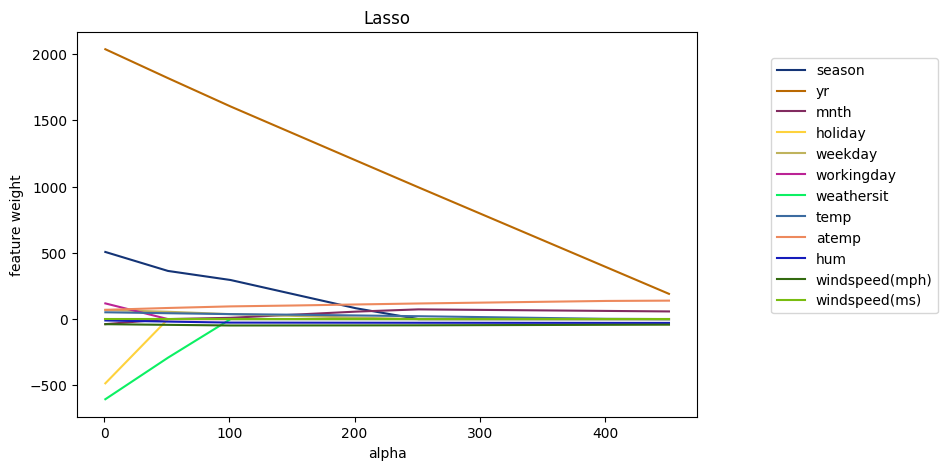

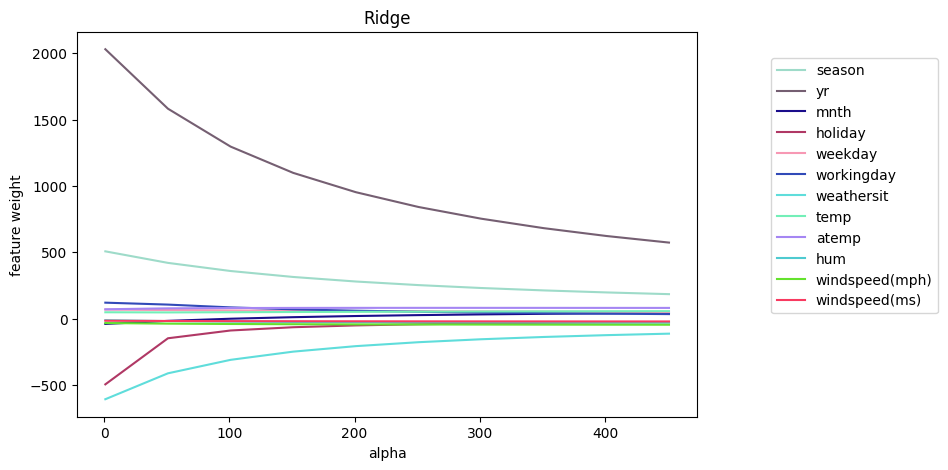

In [22]:
plt.figure(figsize=(8, 5))

for coef, feature in zip(coefs_lasso.T, df.columns):
    plt.plot(alphas, coef, label=feature, color=np.random.rand(3))

plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Lasso")

plt.figure(figsize=(8, 5))
for coef, feature in zip(coefs_ridge.T, df.columns):
    plt.plot(alphas, coef, label=feature, color=np.random.rand(3))

plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Ridge")

plt.show()

Проаналізуйте графіки та дайте відповіді на такі запитання.

1. Який регуляризатор (Ridge або Lasso) агресивніше зменшує ваги при одному й тому самому alpha?
1. Що станеться з вагами Lasso, якщо alpha зробити дуже великим? Поясніть, чому так відбувається.
1. Чи можна стверджувати, що `Lasso` виключає одну з ознак `windspeed` при будь-якому значенні `alpha > 0`? А Ridge? Вважається, що регуляризатор виключає ознаку, якщо коефіцієнт при ньому менший $10^{-3}$.
1. Який із регуляризаторів підійде для відбору неінформативних ознак?


__Відповіді:__

1. Lasso агресивніше зменшує ваги при тому ж alpha
2. Якщо alpha зробити дуже великим у Lasso, більшість або всі ваги ознак наблизяться до нуля. Це відбувається тому, що L1-регуляризація додає штраф до функції втрат, який пропорційний сумі абсолютних значень коефіцієнтів. Велике значення alpha робить цей штраф настільки значним, що модель прагне зменшити всі коефіцієнти до нуля, щоб мінімізувати загальну вартість функції.
3.
Lasso: Так, можна стверджувати, що Lasso виключає одну з ознак windspeed (зокрема, windspeed(ms)) при значенні alpha > 0, оскільки вже при дуже малих значеннях alpha ваги для windspeed(ms) обнуляються.
Ridge: Ні, Ridge не виключає ознаки повністю. Навіть при великих значеннях alpha ваги для ознак windspeed(mph) і windspeed(ms) залишаються близькими, але не рівними нулю. Це пов'язано з тим, що Ridge накладає штраф на суму квадратів коефіцієнтів, що призводить до зменшення їх значень, але не до повного обнулення.
4. Lasso (L1-регуляризація) підходить краще для відбору неінформативних ознак, оскільки здатний обнулювати ваги неважливих змінних, фактично видаляючи їх з моделі. Ridge (L2-регуляризація) зменшує ваги ознак, але не обнуляє їх повністю.

__Загальний висновок__

На основі графіків можна зробити висновок, що Lasso є кращим інструментом для виключення неінформативних ознак з моделі завдяки його здатності обнулювати ваги. Ridge, натомість, більше підходить для моделей, де всі ознаки важливі, але можуть мати занадто великі або малі коефіцієнти, які потребують коригування.

P.S. Я аналізував і свої графіки, і ті, які були першочергово. Чому відрізняються - не розумію.

### Завдання 8

Далі будемо працювати з `Lasso`.

Отже, ми бачимо, що при зміні alpha модель по-різному підбирає коефіцієнти ознак. Нам потрібно вибрати найкраще alpha.

Для цього, по-перше, нам потрібна метрика якості. Будемо використовувати як метрику сам оптимізований функціонал методу найменших квадратів, тобто `Mean Square Error`.

По-друге, потрібно зрозуміти, на яких даних цю метрику рахувати. Не можна вибирати `alpha` за значенням MSE на навчальній вибірці, тому що тоді ми не зможемо оцінити, як модель буде робити передбачення на нових для неї даних. Якщо ми виберемо одне розбиття вибірки на навчальну та тестову (це називається holdout), то налаштуємося на конкретні "нові" дані, і знову можемо перенавчитися. Тому будемо робити декілька розбиттів вибірки, на кожному пробувати різні значення alpha, а потім усереднювати MSE. Найзручніше робити такі розбиття крос-валідацією, тобто розділити вибірку на $K$ частин, і кожного разу брати одну з них як тестову, а з блоків, що залишилися, складати навчальну вибірку.

Робити крос-валідацію для регресії в sklearn зовсім просто: для цього є спеціальний регресор, __LassoCV__, який бере на вхід список із alpha і для кожного з них обчислює MSE на крос-валідації. Після навчання (якщо залишити параметр cv=3 за замовчуванням) регресор буде містити змінну __mse\_path\___, матрицю розміру len(alpha) x k, k = 3 (число блоків у крос-валідації), що містить значення MSE на тесті для відповідних запусків. Крім того, у змінній alpha\_ буде зберігатися вибране значення параметра регуляризації, а в coef\_, традиційно, навчені ваги, що відповідають цьому alpha_.

Зверніть увагу, що регресор може змінювати порядок, у якому він проходить по alphas; для зіставлення з матрицею MSE краще використовувати змінну регресора alphas_.

Навчіть регресор `LassoCV` на всіх параметрах регуляризації з alpha. Побудуйте графік _усередненого_ за рядками `MSE` в залежності від `alpha` (використовуйте для цього функцію `create_plot`).

Виведіть вибране `alpha`, а також пари "ознака-коефіцієнт" для навченого вектора коефіцієнтів.

In [24]:
def create_plot(data, title, xlabel, ylabel, figsize=None):
    size = figsize or (15, 5)
    plt.figure(figsize=size)

    x = map(lambda e: e[0], data)
    y = map(lambda e: e[1], data)
    plt.plot(x, y)

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    plt.grid()
    plt.show()

In [28]:
from sklearn.linear_model import LassoCV

alphas = np.arange(1, 100, 5)

regressor = LassoCV(alphas=alphas, cv=3).fit(X, y)

# Навчання регресора з крос-валідацією
regressor = LassoCV(alphas=alphas, cv=3).fit(X, y)

# Усереднений MSE для кожного alpha
mse_means = np.mean(regressor.mse_path_, axis=1)

# Вивід вибраного alpha та коефіцієнтів
print("Вибране значення alpha:", regressor.alpha_)
print("Коефіцієнти:")

for feature, coef in zip(df.columns[:-1], regressor.coef_):
    print(f"{feature}: {coef}")

Вибране значення alpha: 1
Коефіцієнти:
season: 506.5512786498074
yr: 2036.2316676979037
mnth: -38.07827028932167
holiday: -484.65194618654056
weekday: 68.93837479133958
workingday: 118.4475975866837
weathersit: -604.5667118927049
temp: 51.363260585616366
atemp: 69.91273749012187
hum: -10.352705204636573
windspeed(mph): -38.34106761310847
windspeed(ms): -0.0


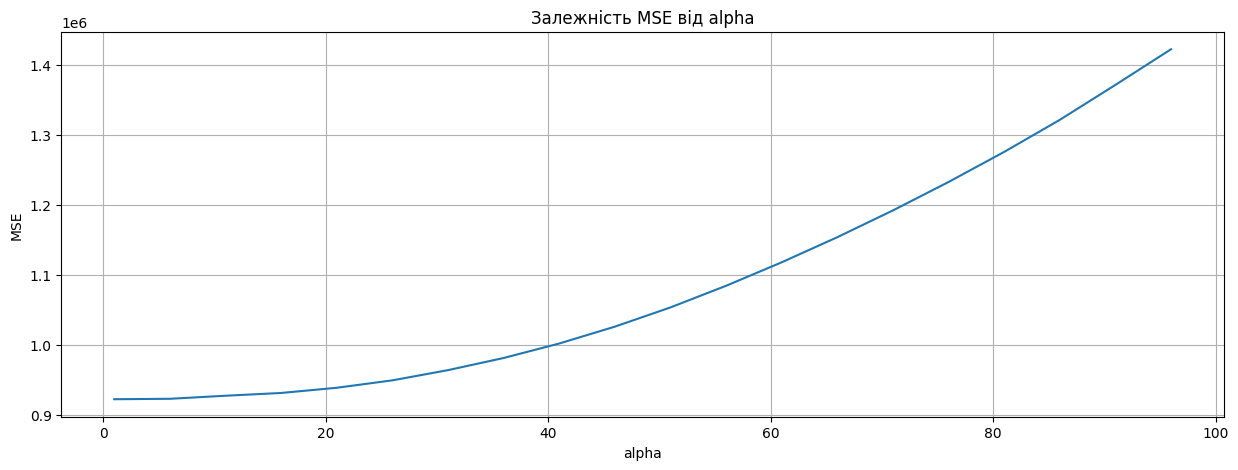

In [29]:
def create_plot(data, title, xlabel, ylabel, figsize=None):
    size = figsize or (15, 5)
    plt.figure(figsize=size)

    # Перетворення map-об'єктів на списки для побудови графіку
    x = list(map(lambda e: e[0], data))
    y = list(map(lambda e: e[1], data))
    plt.plot(x, y)

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    plt.grid()
    plt.show()

# Створення графіка залежності MSE від alpha
create_plot(list(zip(regressor.alphas_, mse_means)), title="Залежність MSE від alpha", xlabel="alpha", ylabel="MSE")

Отже, ми вибрали певний параметр регуляризації. Давайте подивимося, які б ми вибирали alpha, якби ділили вибірку лише один раз на навчальну та тестову, тобто розглянемо траєкторії MSE, що відповідають окремим блокам вибірки.

### Завдання 9

Виведіть значення `alpha`, що відповідають мінімумам `MSE` на кожному розбитті (тобто за стовпцями).
На трьох окремих графіках візуалізуйте стовпці `mse_path_`.


Значення alpha, що відповідають мінімумам MSE на кожному розбитті:
Розбиття 1: Alpha = 1, MSE = 783221.2007323484
Розбиття 2: Alpha = 51, MSE = 606705.6506735483
Розбиття 3: Alpha = 1, MSE = 1234577.1775608219


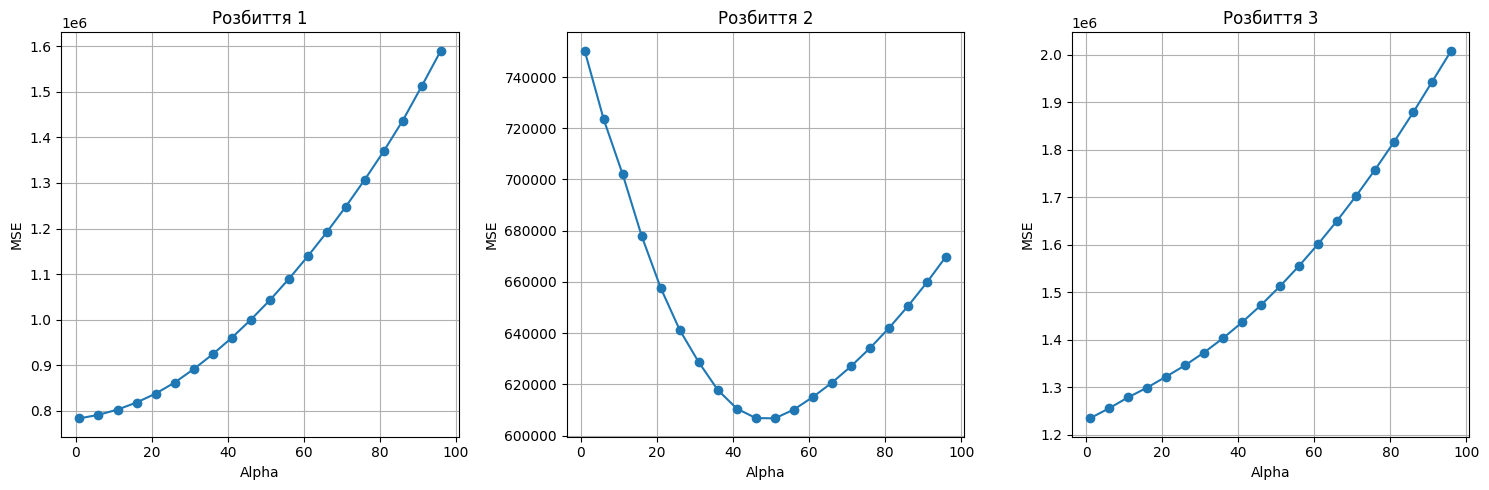

In [30]:
alphas_min_mse = regressor.alphas_[np.argmin(regressor.mse_path_, axis=0)]
mse_min_values = np.min(regressor.mse_path_, axis=0)

print("Значення alpha, що відповідають мінімумам MSE на кожному розбитті:")
for i, (alpha, mse) in enumerate(zip(alphas_min_mse, mse_min_values)):
    print(f"Розбиття {i+1}: Alpha = {alpha}, MSE = {mse}")

# Візуалізація MSE для кожного розбиття
plt.figure(figsize=(15, 5))

# Побудуйте графік для кожного з трьох розбиттів
for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.plot(regressor.alphas_, regressor.mse_path_[:, i], marker='o')
    plt.title(f'Розбиття {i+1}')
    plt.xlabel('Alpha')
    plt.ylabel('MSE')
    plt.grid(True)

plt.tight_layout()
plt.show()



На кожному розбитті оптимальне значення `alpha` своє, і йому відповідає велике MSE на інших розбиттях. Виходить, що ми налаштовуємося на конкретні навчальні та контрольні вибірки. При виборі `alpha` на крос-валідації ми вибираємо дещо "середнє", що даватиме прийнятне значення метрики на різних розбиттях вибірки.

### Завдання 10

Нарешті, як прийнято в аналізі даних, давайте проінтерпретуємо результат. Дайте відповіді на наступні запитання.

#### Запитання 1

В останній навченій моделі виберіть 4 ознаки з найбільшими (позитивними) коефіцієнтами (і випишіть їх), подивіться на візуалізації залежностей `cnt` від цих ознак, які ми зображали у блоці "Ознайомлення з даними". Чи видно зростаючу лінійну залежність `cnt` від цих ознак за графіками? Чи логічно стверджувати (виходячи зі здорового глузду), що чим більше значення цих ознак, тим більше людей захочуть взяти велосипеди?

__Відповідь:__

Найбільші позитивні коефіцієнти мають ознаки:
yr: 2036.23
season: 506.55
workingday: 118.45
weekday: 68.94
yr: Коефіцієнт при yr (рік) є найбільшим. Це означає, що в 2012 році (позначається як 1) кількість прокатів велосипедів значно більша, ніж в 2011 році (позначається як 0). Це логічно, оскільки, з огляду на розвиток системи прокату, кількість прокатів може збільшуватись з часом.

season: season має другий за величиною позитивний коефіцієнт. Це означає, що кількість прокатів зростає в певні сезони, наприклад, літом або весною, коли погода краще і більше людей хочуть взяти велосипеди. Це також логічно, виходячи зі здорового глузду.

workingday: Позитивний коефіцієнт для workingday означає, що в робочі дні кількість прокатів велосипедів зростає. Це може бути пов'язано з використанням велосипедів як транспорту для поїздок на роботу.

weekday: Позитивний коефіцієнт для weekday вказує на зростання кількості прокатів залежно від дня тижня. Залежність може бути слабшою, але вона все ще показує, що певні дні тижня (наприклад, середина тижня) можуть бути більш популярними для прокатів.

Висновок: Так, можна стверджувати, що чим більше значення цих ознак, тим більше людей захочуть взяти велосипеди. Це відповідає здоровому глузду і підтверджується графіками.



#### Запитання 2

Виберіть 3 ознаки з найбільшими за модулем негативними коефіцієнтами (і випишіть їх), подивіться на відповідні візуалізації. Чи видно лінійну залежність, що зменшується? Чи логічно стверджувати, що чим більша величина цих ознак, тим менше людей захочуть взяти велосипеди?

__Відповідь:__

Найбільші за модулем негативні коефіцієнти мають ознаки:
weathersit: -604.57
holiday: -484.65
windspeed(mph): -38.34
Аналіз:

weathersit: Негативний коефіцієнт вказує на те, що коли погода погіршується (значення weathersit збільшується), кількість прокатів зменшується. Це логічно, оскільки в погану погоду (наприклад, дощ або туман) менше людей захочуть брати велосипеди.

holiday: Негативний коефіцієнт для holiday означає, що у святкові дні кількість прокатів зменшується. Це може бути пов'язано з тим, що люди менше подорожують у святкові дні або використовують інші засоби транспорту.

windspeed(mph): Негативний коефіцієнт для швидкості вітру (windspeed) показує, що при збільшенні швидкості вітру кількість прокатів зменшується. Це теж логічно, адже сильний вітер може зробити поїздку на велосипеді менш комфортною.

Висновок: Так, можна стверджувати, що чим більше значення цих ознак, тим менше людей захочуть взяти велосипеди. Це відповідає реальному життю і підтверджується графіками.

In [ ]:
# ???

#### Запитання 3

Випишіть ознаки з коефіцієнтами, близькими до нуля (< 1e-3). Як ви думаєте, чому модель виключила їх із моделі (знову подивіться на графіки)? Чи правда, що вони ніяк не впливають на попит на велосипеди?

__Відповідь:__

windspeed(ms): -0.0
Аналіз:

windspeed(ms) має коефіцієнт, рівний -0. Це означає, що модель виключила цю ознаку, оскільки вона повністю корелює з ознакою windspeed(mph) (швидкість вітру в милях за годину). Обидві ознаки передають ту саму інформацію, лише в різних одиницях, тому модель залишила тільки одну з них (windspeed(mph)).
Висновок: Ознака windspeed(ms) не впливає на попит на велосипеди, оскільки її інформація вже врахована іншою ознакою windspeed(mph).

In [ ]:
# ???

### Висновок
Отже, ми подивилися, як можна стежити за адекватністю лінійної моделі, як відбирати ознаки і як грамотно, за можливості не налаштовуючись на якусь конкретну порцію даних, підбирати коефіцієнт регуляризації.

Варто зазначити, що за допомогою крос-валідації зручно підбирати лише невелику кількість параметрів. (1, 2, максимум 3), тому що для кожної допустимої їх комбінації нам доводиться декілька разів навчати модель. Такий процес займає багато часу, особливо якщо треба навчатися на великих обсягах даних.